In [16]:
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import sampler
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
img_transforms=torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32,32)),
     torchvision.transforms.ToTensor(),#Originally image is a PIL.Image.Image object
     torchvision.transforms.Normalize((0.5,),(0.5,))
    ]
)

In [4]:
train_dataset = datasets.MNIST(root='data',
                                train=True,
                                transform=img_transforms,
                                download=True)

valid_dataset = datasets.MNIST(root='data',
                                train=True,
                                transform=img_transforms)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=img_transforms)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.46MB/s]


In [5]:
validation_fraction=0.1
validation_num=int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - validation_num)
valid_indices = torch.arange(60000 - validation_num, 60000)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [6]:
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=valid_sampler)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          sampler=train_sampler)

test_loader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [7]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([3, 0, 8, 6, 9, 2, 0, 0, 0, 4])


## LeNet-5 Architecture

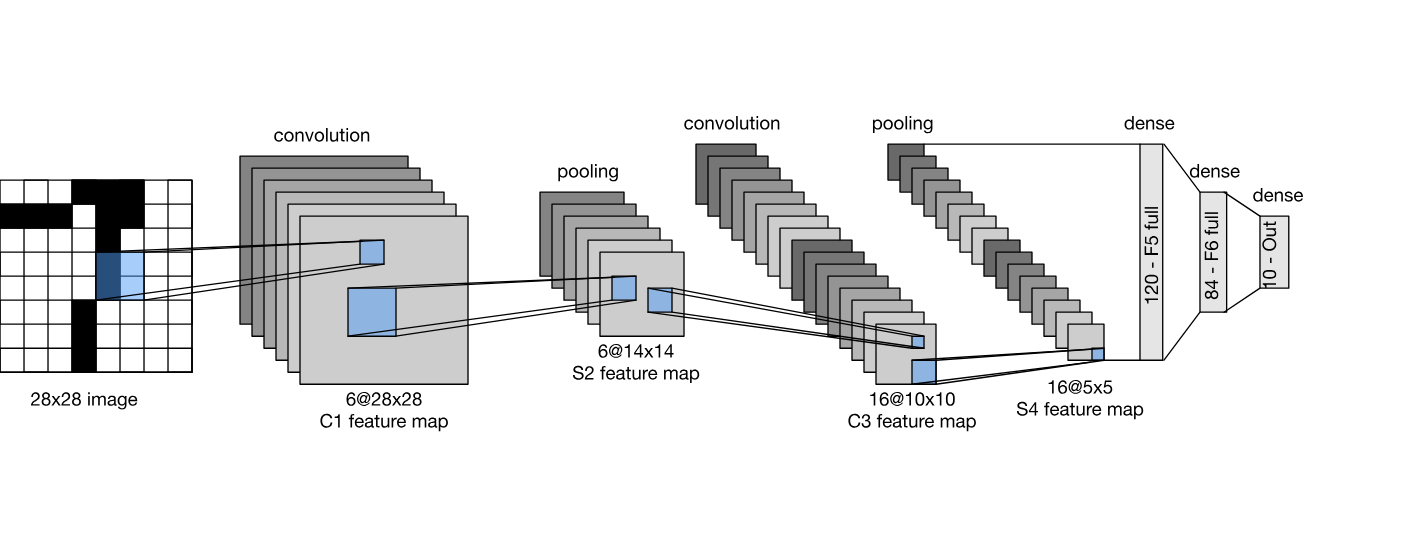

In [12]:
class LeNet5(torch.nn.Module):
  def __init__(self,num_classes,grayscale):
    super().__init__()
    self.grayscale=grayscale
    if self.grayscale:
      in_channels=1
    else:
      in_channels=3
    self.feature_extractor=torch.nn.Sequential(
        torch.nn.Conv2d(in_channels,6,kernel_size=5),
        torch.nn.Tanh(),
        torch.nn.MaxPool2d(kernel_size=2),
        torch.nn.Conv2d(6,16,kernel_size=5),
        torch.nn.Tanh(),
        torch.nn.MaxPool2d(kernel_size=2)
    )

    self.classifier=torch.nn.Sequential(
        torch.nn.Linear(16*5*5,120),
        torch.nn.Tanh(),
        torch.nn.Linear(120,84),
        torch.nn.Tanh(),
        torch.nn.Linear(84,num_classes)
    )

  def forward(self,X):
    X=self.feature_extractor(X)
    X=torch.flatten(X,1)  # here what 1 means is start flattening from dimension 1 ie leave dim 0(batch dimension) alone
    logits=self.classifier(X)
    return logits

  def compute_accuracy(self,data_loader,device):
    correct_preds=0
    total_preds=0
    total_batches=0
    for batch_idx,(inputs,targets) in enumerate(data_loader):
      inputs=inputs.to(device)
      targets=targets.to(device)
      logits=self.forward(inputs)
      probs=F.softmax(logits,dim=1)
      preds=torch.argmax(probs,dim=1)
      correct_preds+=torch.sum(preds==targets)
      total_preds+=targets.size(0)
      total_batches+=1

    accuracy=correct_preds/total_preds
    return accuracy*100

  def train_model(self,num_epochs, train_loader,valid_loader, test_loader,device,logging_interval=50):
    optimizer = torch.optim.SGD(self.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          factor=0.1,
                                                          mode='max',
                                                          verbose=True)
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

    for epoch in range(num_epochs):
      self.train()
      for batch_idx,(img,targets) in enumerate(train_loader):
        img=img.to(device)
        targets=targets.to(device)

        logits=self.forward(img)

        loss=F.cross_entropy(logits,targets)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())

        if not batch_idx % logging_interval:
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} \t Batch {batch_idx:04d}/{len(train_loader):04d} \t Loss: {loss:.4f}')

        self.eval()
      with torch.no_grad():
          train_acc = self.compute_accuracy(train_loader, device=device)
          valid_acc = self.compute_accuracy(valid_loader, device=device)
          print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                f'| Train: {train_acc :.2f}% '
                f'| Validation: {valid_acc :.2f}%')
          train_acc_list.append(train_acc.item())
          valid_acc_list.append(valid_acc.item())

          scheduler.step(valid_acc_list[-1])

    test_acc = self.compute_accuracy(test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list



In [13]:
model=LeNet5(num_classes=10,grayscale=True)

In [14]:
model = model.to(DEVICE)

In [15]:
minibatch_loss_list, train_acc_list, valid_acc_list = model.train_model(
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    device=DEVICE,
    logging_interval=100)

Epoch: 001/015 	 Batch 0000/0210 	 Loss: 2.3051
Epoch: 001/015 	 Batch 0100/0210 	 Loss: 0.5005
Epoch: 001/015 	 Batch 0200/0210 	 Loss: 0.3590
Epoch: 001/015 | Train: 92.36% | Validation: 94.08%
Epoch: 002/015 	 Batch 0000/0210 	 Loss: 0.2210
Epoch: 002/015 	 Batch 0100/0210 	 Loss: 0.1809
Epoch: 002/015 	 Batch 0200/0210 	 Loss: 0.1466
Epoch: 002/015 | Train: 95.53% | Validation: 96.68%
Epoch: 003/015 	 Batch 0000/0210 	 Loss: 0.1724
Epoch: 003/015 	 Batch 0100/0210 	 Loss: 0.1161
Epoch: 003/015 	 Batch 0200/0210 	 Loss: 0.0925
Epoch: 003/015 | Train: 96.88% | Validation: 97.52%
Epoch: 004/015 	 Batch 0000/0210 	 Loss: 0.1226
Epoch: 004/015 	 Batch 0100/0210 	 Loss: 0.1275
Epoch: 004/015 	 Batch 0200/0210 	 Loss: 0.1313
Epoch: 004/015 | Train: 97.46% | Validation: 97.85%
Epoch: 005/015 	 Batch 0000/0210 	 Loss: 0.0627
Epoch: 005/015 	 Batch 0100/0210 	 Loss: 0.1243
Epoch: 005/015 	 Batch 0200/0210 	 Loss: 0.0926
Epoch: 005/015 | Train: 97.87% | Validation: 97.92%
Epoch: 006/015 	 Bat

In [22]:
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix


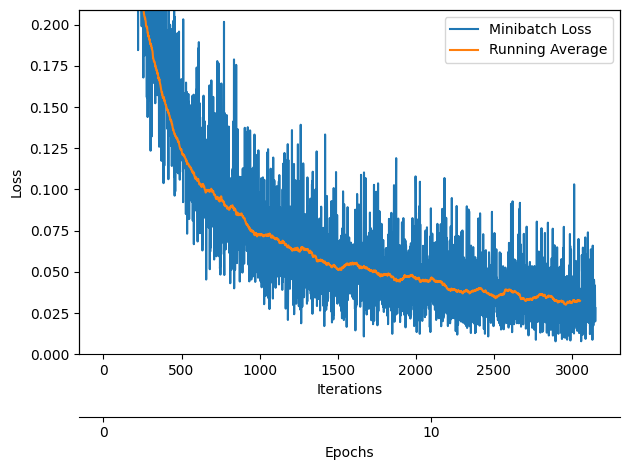

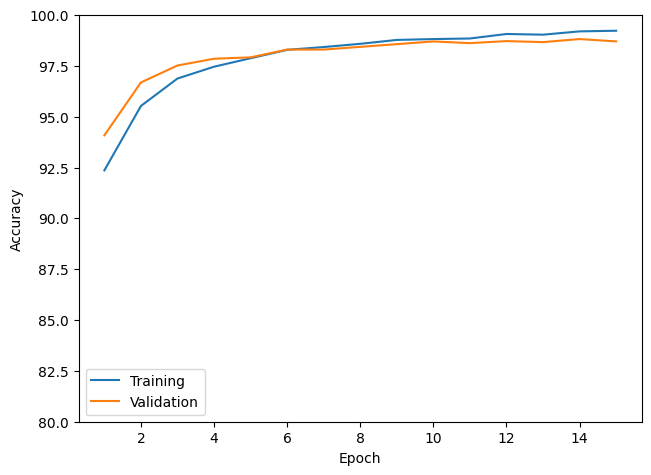

In [23]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

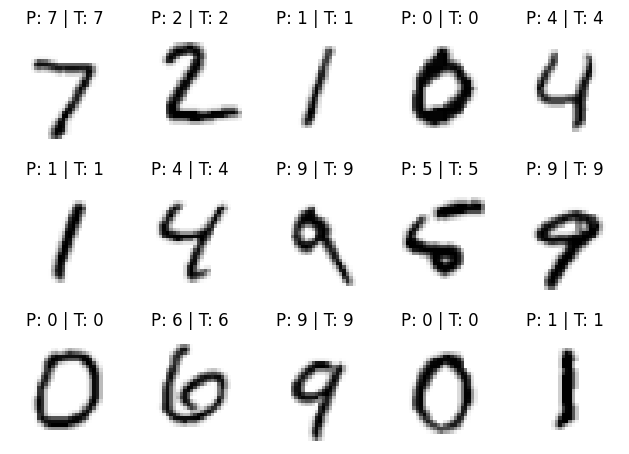

In [24]:
model.cpu()
show_examples(model=model, data_loader=test_loader)